In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from sklearn.metrics import r2_score

In [2]:
df = pd.read_csv("../../../../estsoft/data/train.csv")

# Preprocessing

### Fill Null

In [3]:
def fill_null(df:pd.DataFrame, time_before:list, time:list, time_after:list):
    df_fill = pd.DataFrame()
    for i in range(len(time_before)):
        df_null = df[df['datetime']==time[i]]
        df_concat = pd.concat([df[df['datetime']==time_before[i]], df[df['datetime']==time_after[i]]])

        # null값의 앞뒤 시간의 평균값 계산 및 저장
        ab_mean = pd.DataFrame(df_concat.groupby(['prediction_unit_id'])['target'].sum()/2).reset_index()
        df_merge = pd.merge(df_null, ab_mean, how='left', on='prediction_unit_id').drop(columns='target_x').rename(columns={'target_y':'target'})
        df_fill = pd.concat([df_fill, df_merge])

        # null값이 있는 행 drop
        df = df.drop(df_null.index)

    df = pd.concat([df, df_fill]).reset_index(drop=True).sort_values(by='datetime')
    return df

In [4]:
df_prod =df[df['is_consumption']==0]
df_cons = df[df['is_consumption']==1]

time_before = ['2022-10-30 02:00:00', '2022-03-27 02:00:00', '2023-03-26 02:00:00', '2021-10-31 02:00:00']
time = ['2022-10-30 03:00:00', '2022-03-27 03:00:00', '2023-03-26 03:00:00', '2021-10-31 03:00:00']
time_after = ['2022-10-30 04:00:00', '2022-03-27 04:00:00', '2023-03-26 04:00:00', '2021-10-31 04:00:00']

df_prod = fill_null(df_prod, time_before, time, time_after)
df_cons = fill_null(df_cons, time_before, time, time_after)

### Index 지정

In [5]:
df_prod['datetime'] = pd.to_datetime(df_prod['datetime'])
print(df_prod.info())
df_prod.set_index('datetime', drop=True, inplace=True) 

<class 'pandas.core.frame.DataFrame'>
Index: 1009176 entries, 0 to 1008853
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   county              1009176 non-null  int64         
 1   is_business         1009176 non-null  int64         
 2   product_type        1009176 non-null  int64         
 3   target              1009176 non-null  float64       
 4   is_consumption      1009176 non-null  int64         
 5   datetime            1009176 non-null  datetime64[ns]
 6   data_block_id       1009176 non-null  int64         
 7   row_id              1009176 non-null  int64         
 8   prediction_unit_id  1009176 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 77.0 MB
None


In [6]:
df_cons['datetime'] = pd.to_datetime(df_cons['datetime'])
print(df_cons.info())
df_cons.set_index('datetime', drop=True, inplace=True)

<class 'pandas.core.frame.DataFrame'>
Index: 1009176 entries, 0 to 1008853
Data columns (total 9 columns):
 #   Column              Non-Null Count    Dtype         
---  ------              --------------    -----         
 0   county              1009176 non-null  int64         
 1   is_business         1009176 non-null  int64         
 2   product_type        1009176 non-null  int64         
 3   target              1009176 non-null  float64       
 4   is_consumption      1009176 non-null  int64         
 5   datetime            1009176 non-null  datetime64[ns]
 6   data_block_id       1009176 non-null  int64         
 7   row_id              1009176 non-null  int64         
 8   prediction_unit_id  1009176 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(7)
memory usage: 77.0 MB
None


### df 분리

In [7]:
# f"df_prod{n}"
df_prod_list = []
for id in df_prod['prediction_unit_id'].unique():
    exec(f"df_prod{id} = df_prod[df_prod['prediction_unit_id']=={id}]")
    exec(f"df_prod_list.append('df_prod{id}')")

print(df_prod_list)
len(df_prod_list)

['df_prod0', 'df_prod33', 'df_prod34', 'df_prod35', 'df_prod36', 'df_prod37', 'df_prod38', 'df_prod39', 'df_prod40', 'df_prod41', 'df_prod42', 'df_prod43', 'df_prod44', 'df_prod46', 'df_prod47', 'df_prod48', 'df_prod49', 'df_prod50', 'df_prod51', 'df_prod52', 'df_prod53', 'df_prod54', 'df_prod55', 'df_prod56', 'df_prod57', 'df_prod58', 'df_prod59', 'df_prod60', 'df_prod32', 'df_prod31', 'df_prod45', 'df_prod29', 'df_prod30', 'df_prod2', 'df_prod3', 'df_prod4', 'df_prod5', 'df_prod6', 'df_prod7', 'df_prod8', 'df_prod9', 'df_prod10', 'df_prod11', 'df_prod12', 'df_prod13', 'df_prod14', 'df_prod1', 'df_prod28', 'df_prod27', 'df_prod26', 'df_prod25', 'df_prod15', 'df_prod23', 'df_prod22', 'df_prod24', 'df_prod20', 'df_prod19', 'df_prod18', 'df_prod17', 'df_prod16', 'df_prod21', 'df_prod63', 'df_prod61', 'df_prod62', 'df_prod64', 'df_prod66', 'df_prod65', 'df_prod67', 'df_prod68']


69

In [8]:
# f"df_cons{n}"
df_cons_list = []
for id in df_cons['prediction_unit_id'].unique():
    exec(f"df_cons{id} = df_cons[df_cons['prediction_unit_id']=={id}]")
    exec(f"df_cons_list.append('df_cons{id}')")

print(df_cons_list)
len(df_cons_list)

['df_cons0', 'df_cons33', 'df_cons34', 'df_cons35', 'df_cons36', 'df_cons37', 'df_cons38', 'df_cons39', 'df_cons40', 'df_cons41', 'df_cons42', 'df_cons43', 'df_cons44', 'df_cons46', 'df_cons47', 'df_cons48', 'df_cons49', 'df_cons50', 'df_cons51', 'df_cons52', 'df_cons53', 'df_cons54', 'df_cons55', 'df_cons56', 'df_cons57', 'df_cons58', 'df_cons59', 'df_cons60', 'df_cons32', 'df_cons31', 'df_cons45', 'df_cons29', 'df_cons30', 'df_cons2', 'df_cons3', 'df_cons4', 'df_cons5', 'df_cons6', 'df_cons7', 'df_cons8', 'df_cons9', 'df_cons10', 'df_cons11', 'df_cons12', 'df_cons13', 'df_cons14', 'df_cons1', 'df_cons28', 'df_cons27', 'df_cons26', 'df_cons25', 'df_cons15', 'df_cons23', 'df_cons22', 'df_cons24', 'df_cons20', 'df_cons19', 'df_cons18', 'df_cons17', 'df_cons16', 'df_cons21', 'df_cons63', 'df_cons61', 'df_cons62', 'df_cons64', 'df_cons66', 'df_cons65', 'df_cons67', 'df_cons68']


69

# Arima with Scaling

In [9]:
def acf_pacf_plot(timeseries:pd.DataFrame, target_name:str):
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(211)
    fig = plot_acf(timeseries[target_name].squeeze(), lags=40, ax=ax1)
    ax2 = fig.add_subplot(212)
    fig = plot_pacf(timeseries[target_name].squeeze(), lags=40, ax=ax2)

In [10]:
tst_size = 96
def use_arima(timeseries:pd.DataFrame, target_name:str='target', tst_size:int=tst_size, p:int=0, d:int=0, q:int=0, scale:bool=False):
    df = timeseries[target_name]
    trn, tst = df[:-tst_size], df[-tst_size:]

    # scale
    if scale == True:
        scaler = MinMaxScaler()
        index = trn.index
        trn = scaler.fit_transform(trn.to_numpy(dtype=np.float32).flatten().reshape(-1,1))
        trn = pd.DataFrame(trn).set_index(index)

    # train & predict
    arima = ARIMA(trn, order=(p,d,q)).fit()
    prd = arima.predict('2023-05-28 00:00:00', '2023-05-31 23:00:00')
    
    # unscale
    if scale == True:
        prd = scaler.inverse_transform(prd.to_numpy(dtype=np.float32).flatten().reshape(-1,1))
        prd = pd.DataFrame(prd).set_index(tst.index)
        
    # graph
    plt.figure(figsize=(12,5))
    plt.plot(tst, label='origin')
    plt.plot(prd, label='prd')
    plt.legend()
    plt.title(f'arima({p},{d},{q}), MSE:{mse(tst,prd):.4f}, MAPE:{mape(tst, prd)*100:.4f}, MAE:{mae(tst, prd):.4f}, r2:{r2_score(tst, prd):.4f}')

## Prod0

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


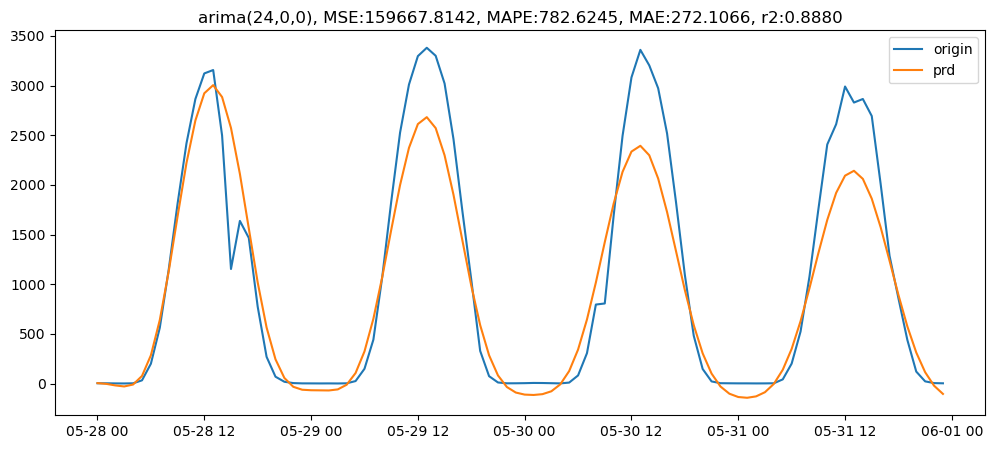

In [15]:
use_arima(df_prod0, p=24, d=0, q=0, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


<class 'pandas.core.frame.DataFrame'>


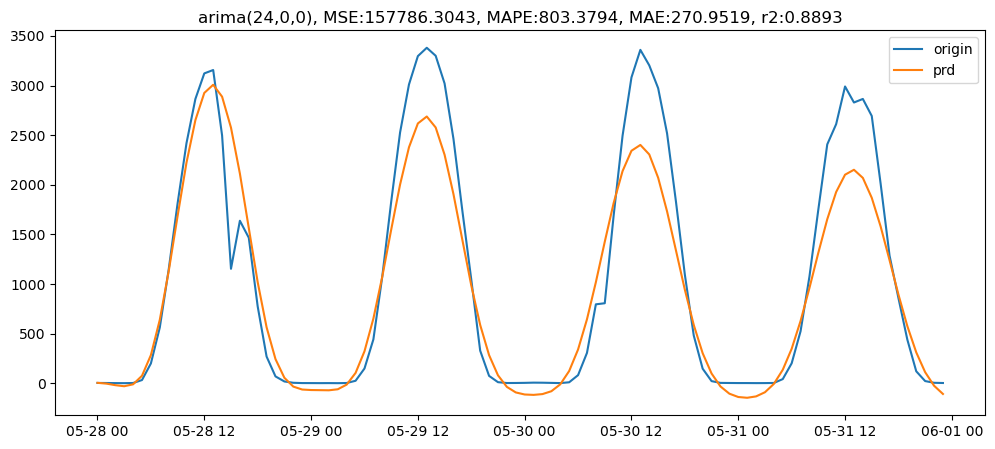

In [16]:
use_arima(df_prod0, p=24, d=0, q=0, scale=True)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


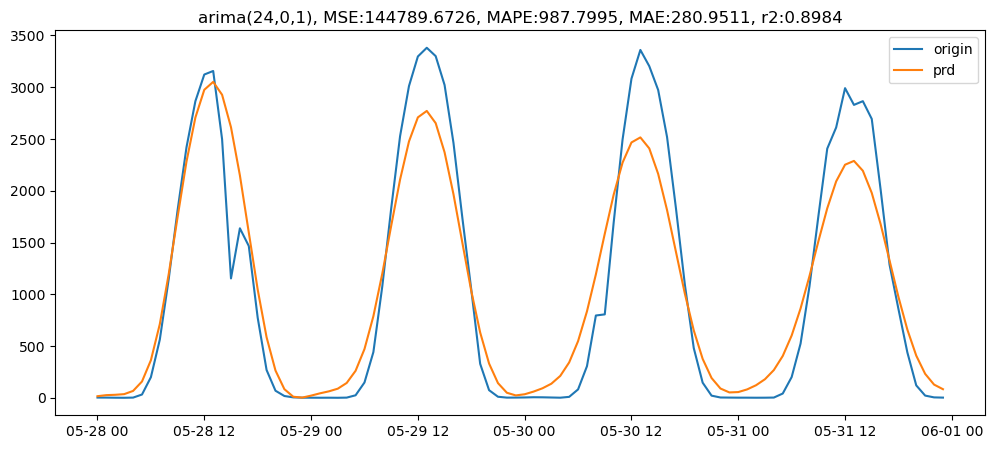

In [17]:
use_arima(df_prod0, p=24, d=0, q=1, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


<class 'pandas.core.frame.DataFrame'>


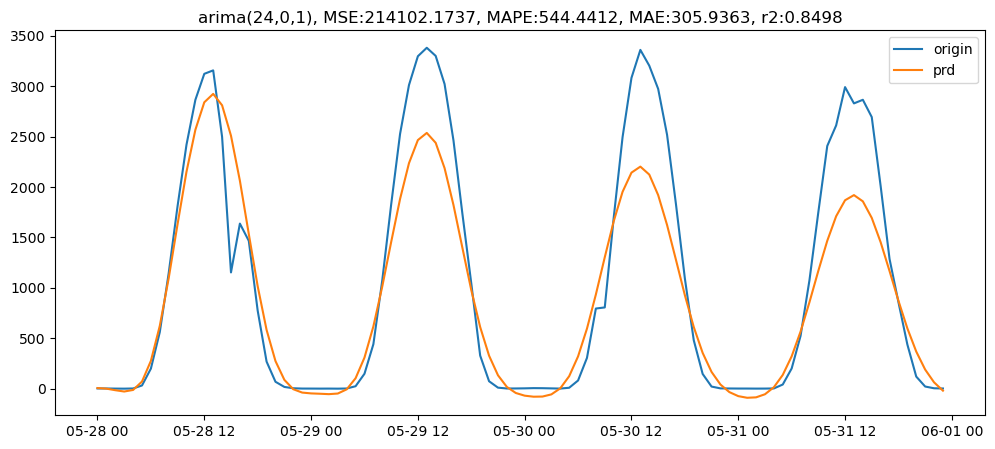

In [18]:
use_arima(df_prod0, p=24, d=0, q=1, scale=True)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


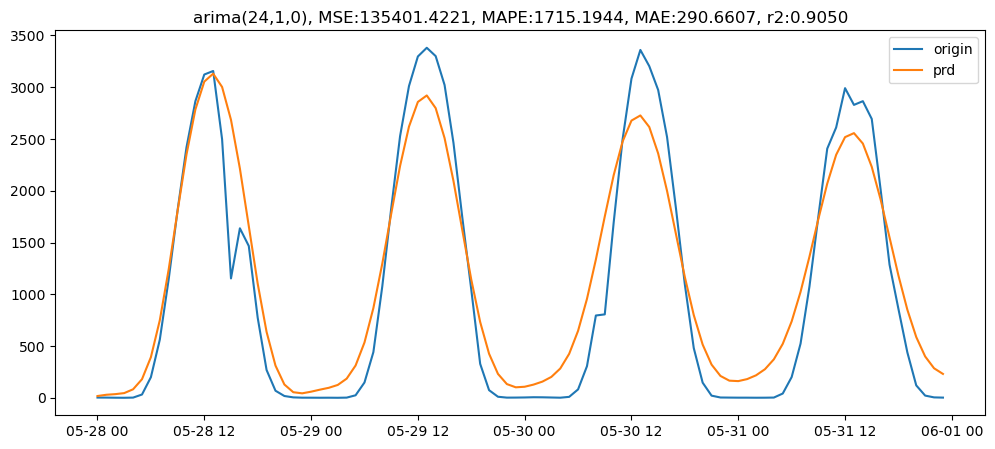

In [21]:
use_arima(df_prod0, p=24, d=1, q=0, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


<class 'pandas.core.frame.DataFrame'>


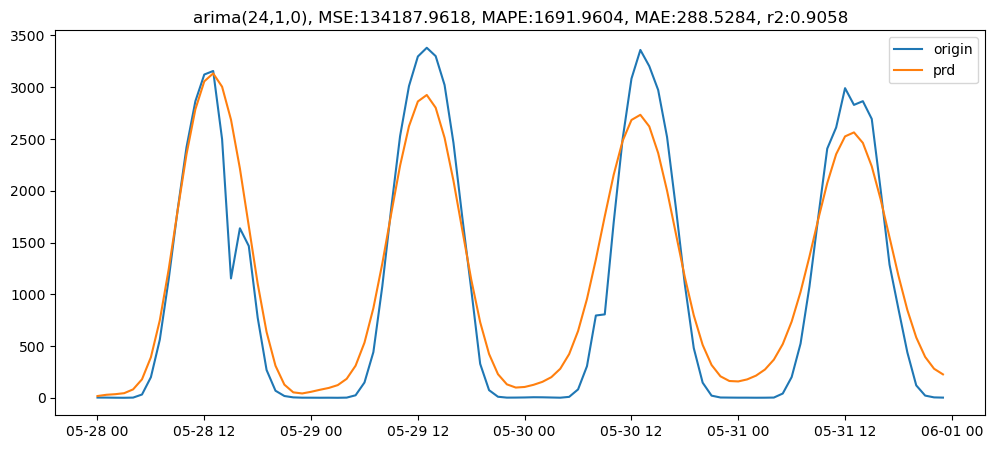

In [22]:
use_arima(df_prod0, p=24, d=1, q=0, scale=True)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/leejo/lib/python

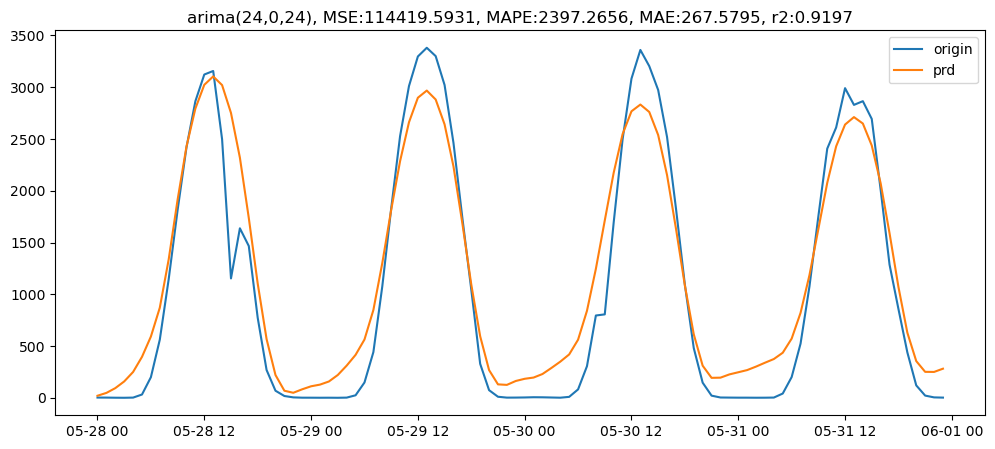

In [39]:
use_arima(df_prod0, p=24, d=0, q=24, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/leejo/lib/python

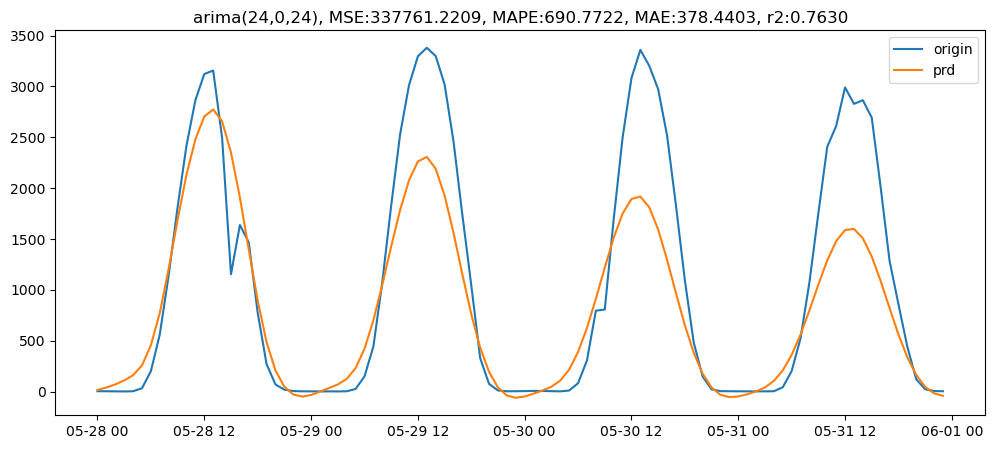

In [40]:
use_arima(df_prod0, p=24, d=0, q=24, scale=True)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


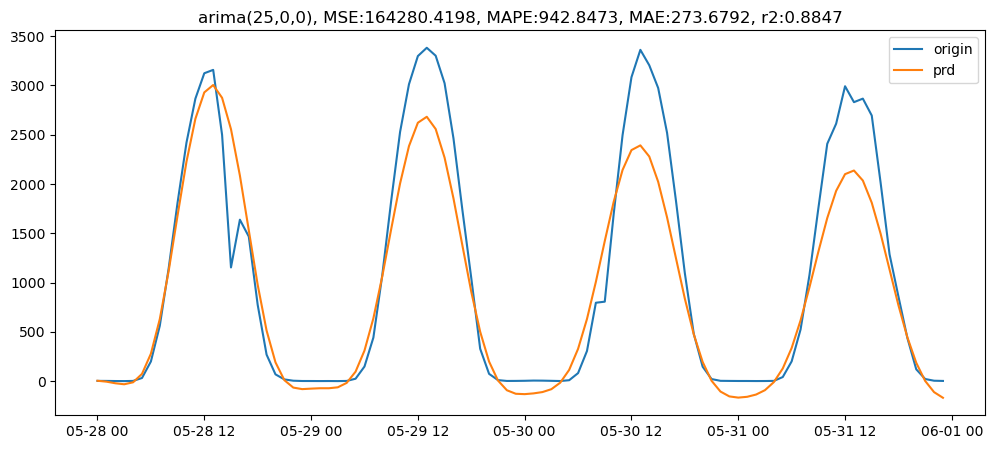

In [41]:
use_arima(df_prod0, p=25, d=0, q=0, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


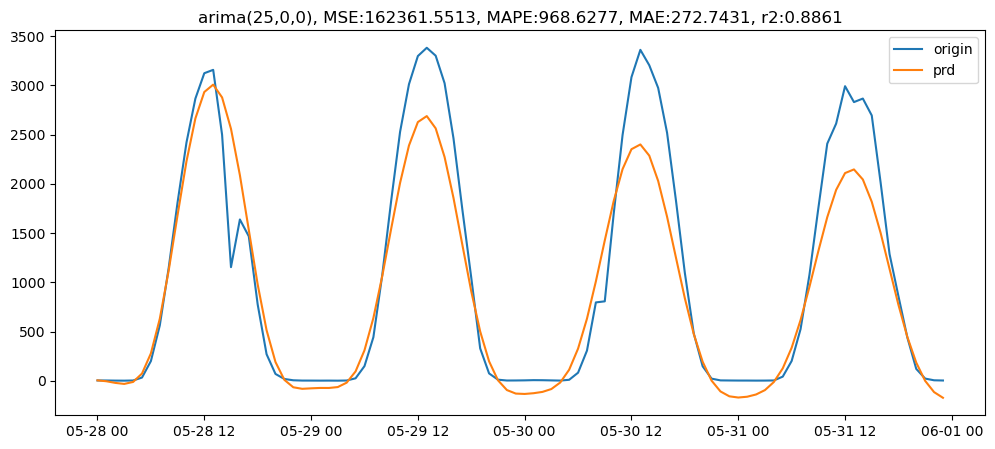

In [42]:
use_arima(df_prod0, p=25, d=0, q=0, scale=True)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/leejo/lib/python

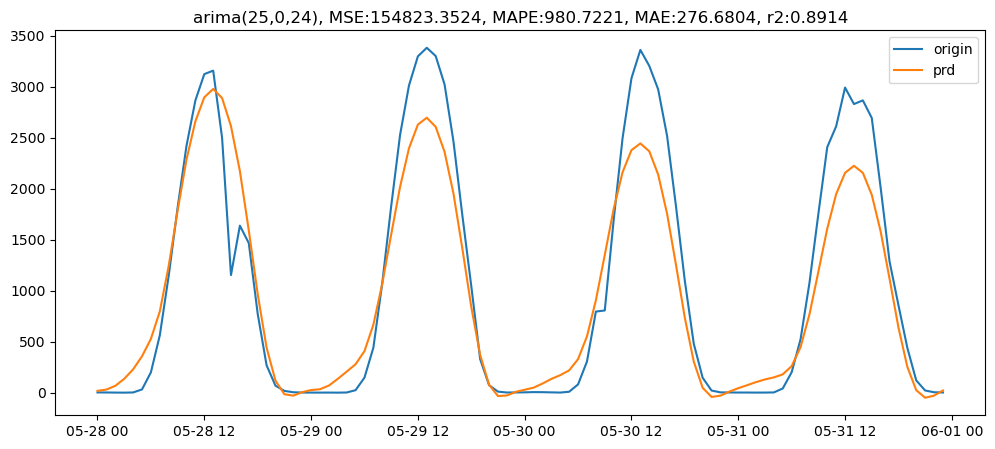

In [43]:
use_arima(df_prod0, p=25, d=0, q=24, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/leejo/lib/python

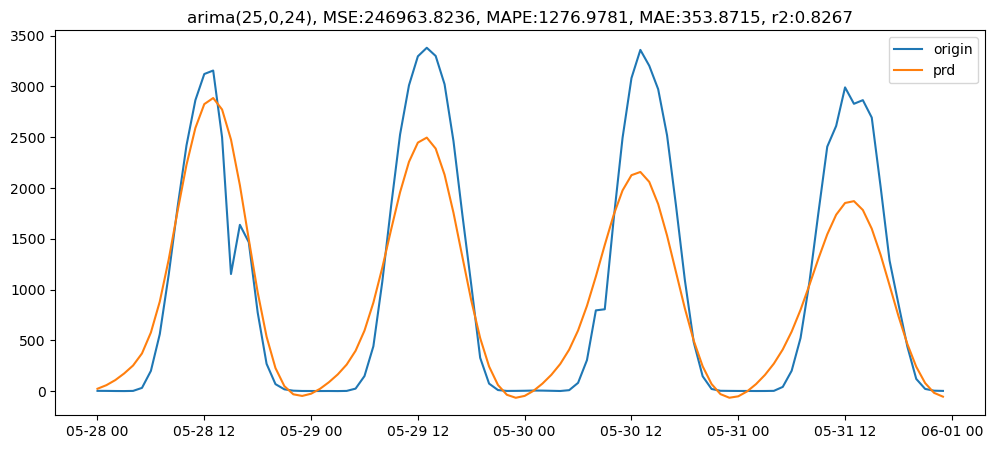

In [44]:
use_arima(df_prod0, p=25, d=0, q=24, scale=True)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/leejo/lib/python

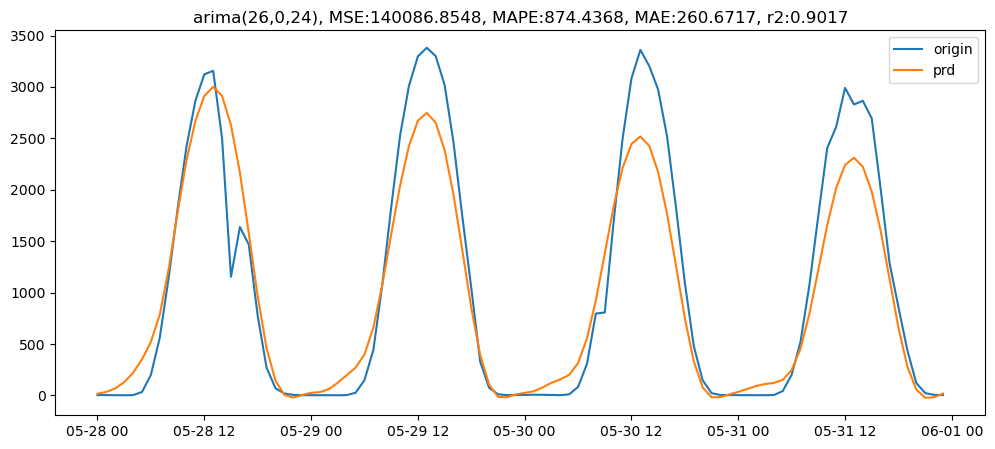

In [45]:
use_arima(df_prod0, p=26, d=0, q=24, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/leejo/lib/python

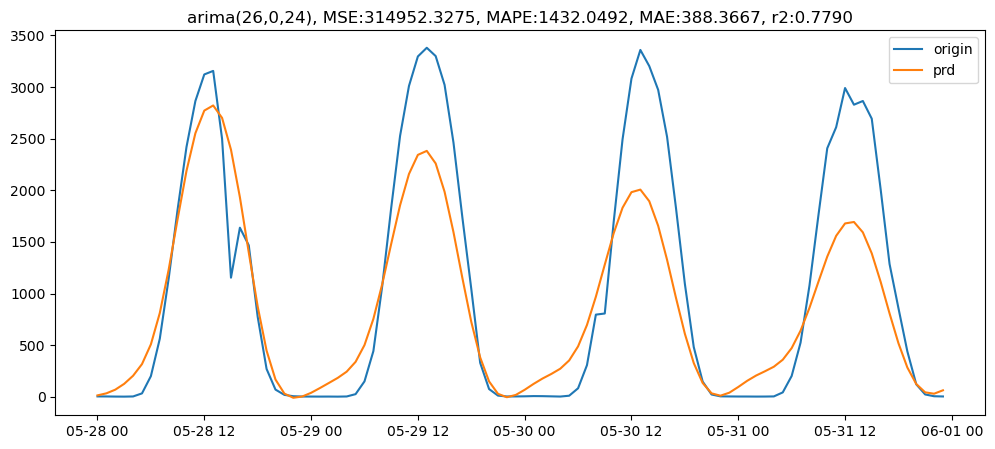

In [46]:
use_arima(df_prod0, p=26, d=0, q=24, scale=True)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/leejo/lib/python

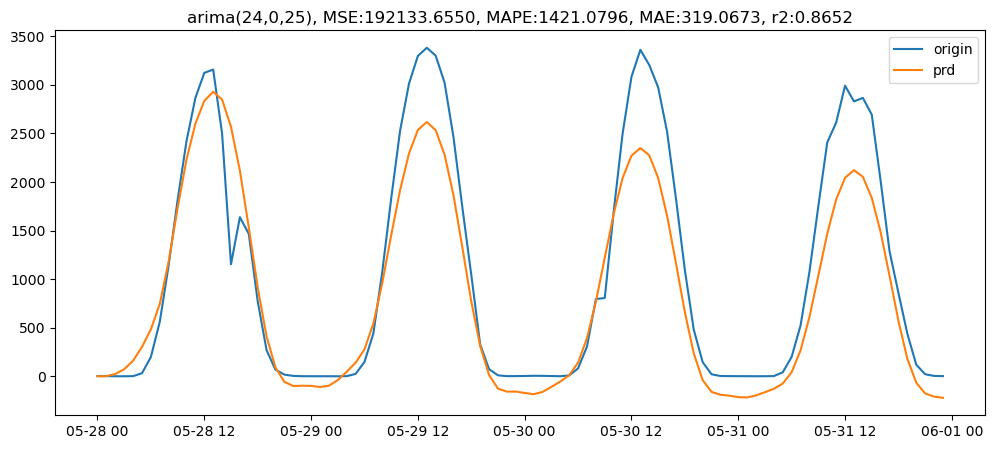

In [47]:
use_arima(df_prod0, p=24, d=0, q=25, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/leejo/lib/python

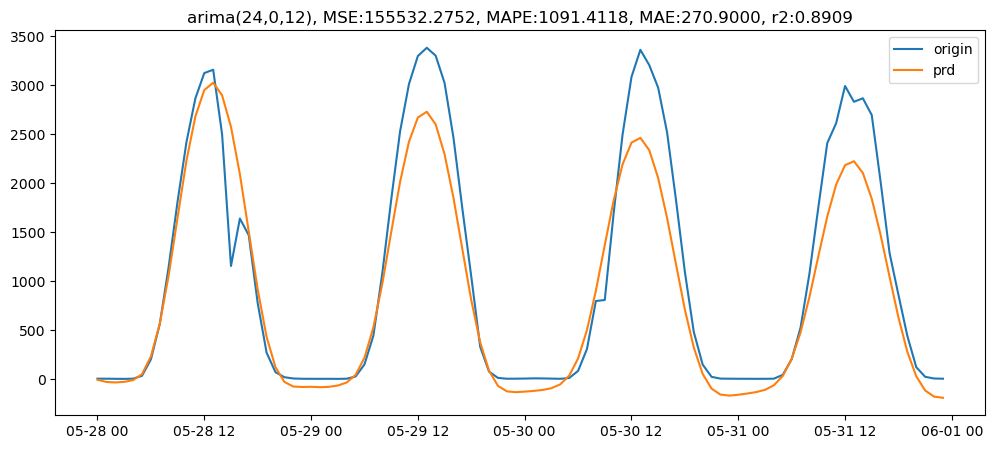

In [48]:
use_arima(df_prod0, p=24, d=0, q=12, scale=False)

## cons0

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


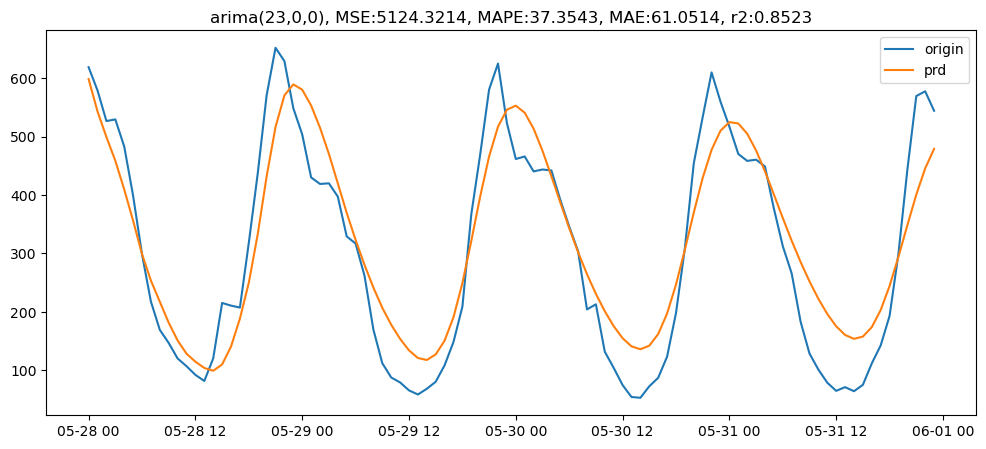

In [49]:
use_arima(df_cons0, p=23, d=0, q=0, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


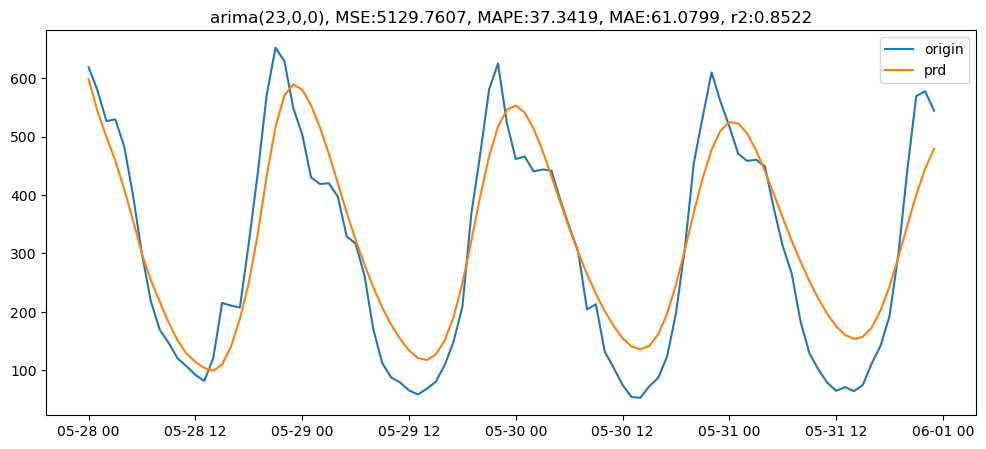

In [50]:
use_arima(df_cons0, p=23, d=0, q=0, scale=True)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


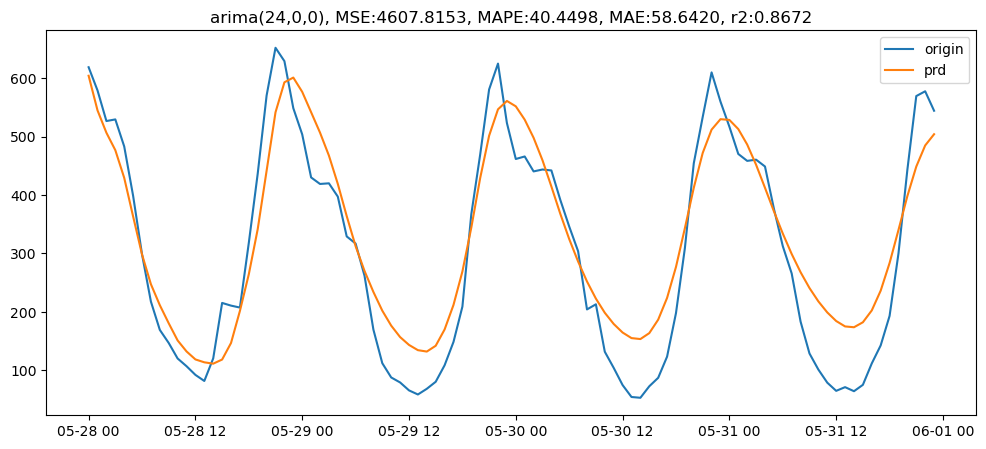

In [19]:
use_arima(df_cons0, p=24, d=0, q=0, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


<class 'pandas.core.frame.DataFrame'>


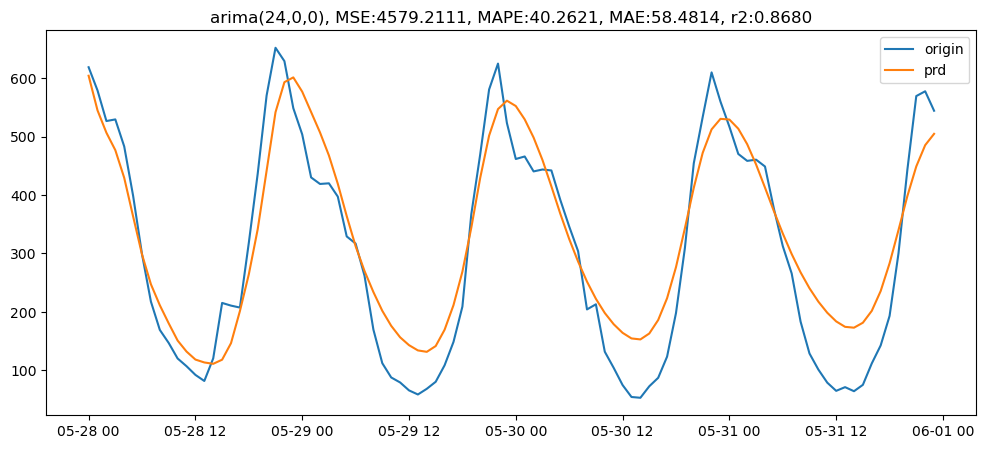

In [20]:
use_arima(df_cons0, p=24, d=0, q=0, scale=True)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


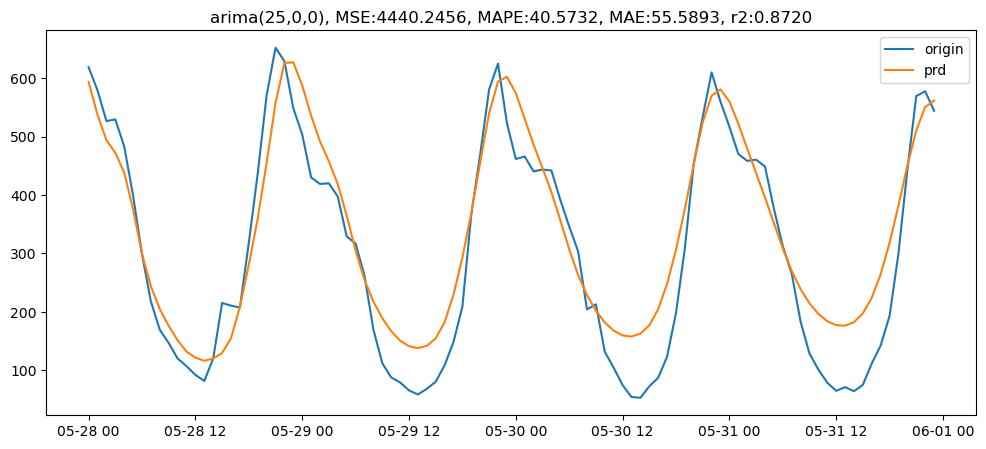

In [51]:
use_arima(df_cons0, p=25, d=0, q=0, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


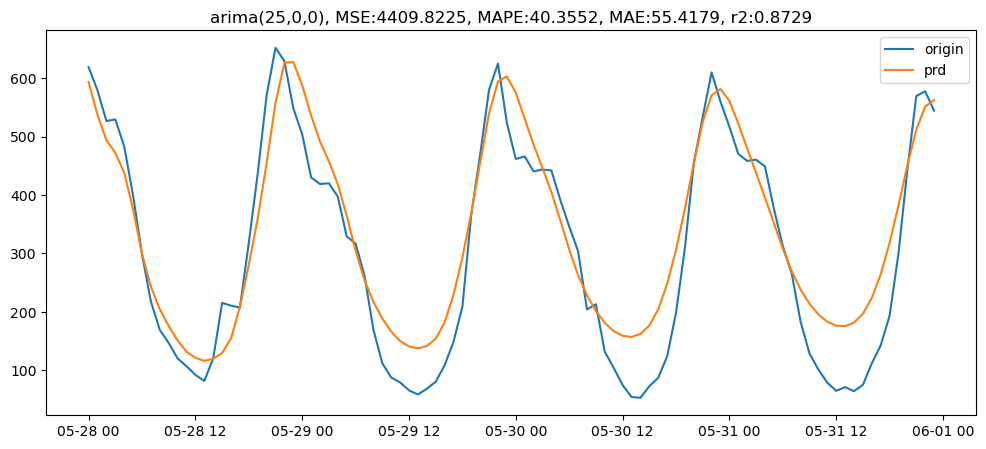

In [52]:
use_arima(df_cons0, p=25, d=0, q=0, scale=True)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


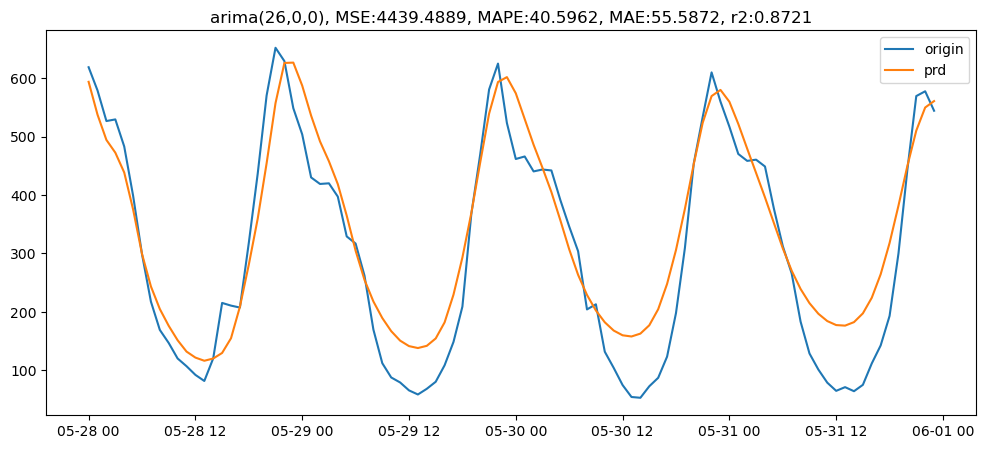

In [53]:
use_arima(df_cons0, p=26, d=0, q=0, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


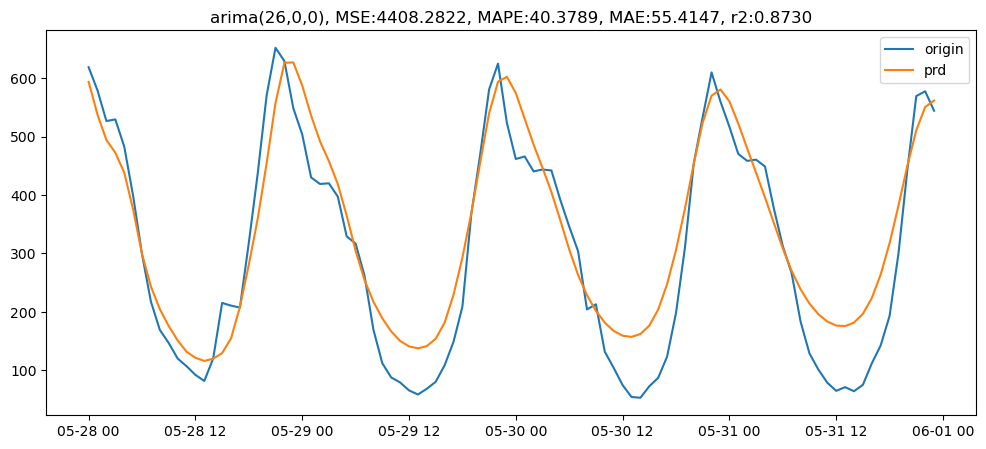

In [54]:
use_arima(df_cons0, p=26, d=0, q=0, scale=True)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


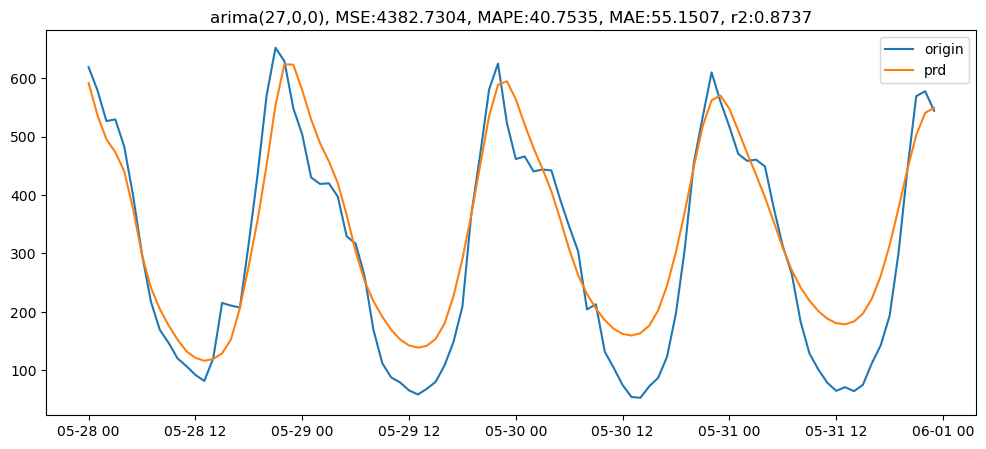

In [56]:
use_arima(df_cons0, p=27, d=0, q=0, scale=True)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


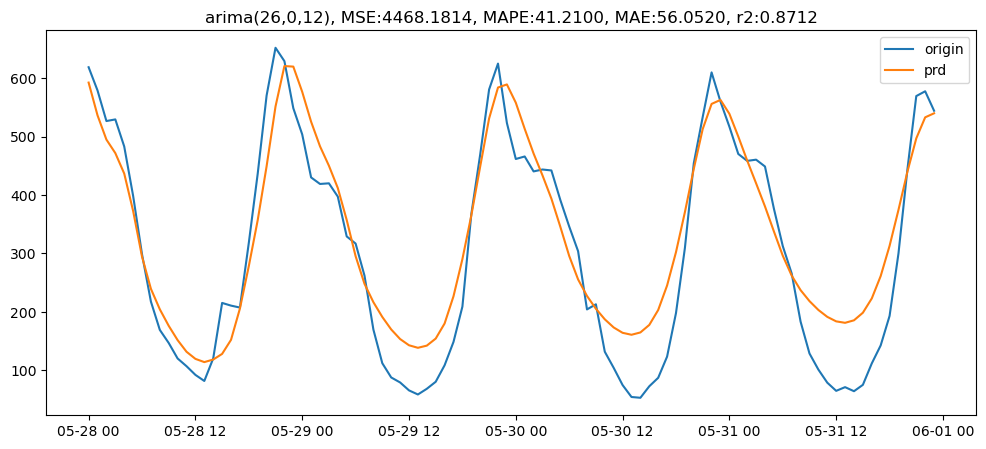

In [57]:
use_arima(df_cons0, p=26, d=0, q=12, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


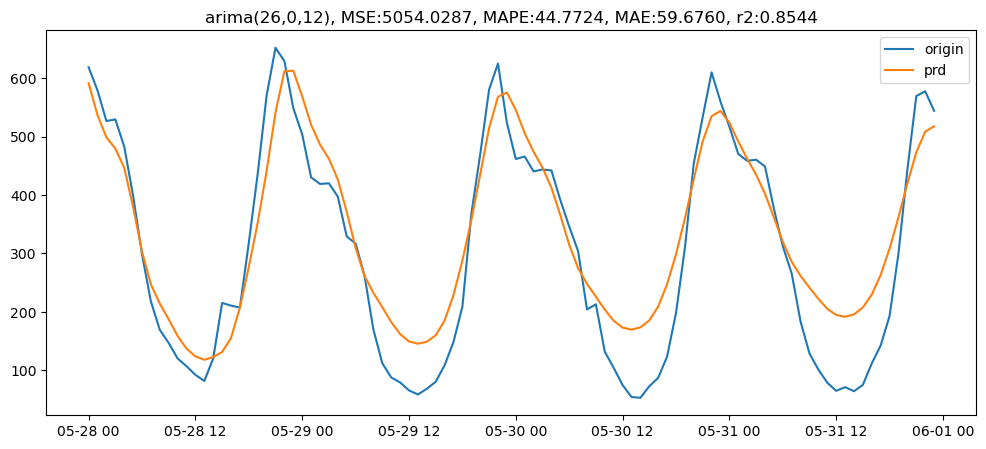

In [59]:
use_arima(df_cons0, p=26, d=0, q=12, scale=True)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


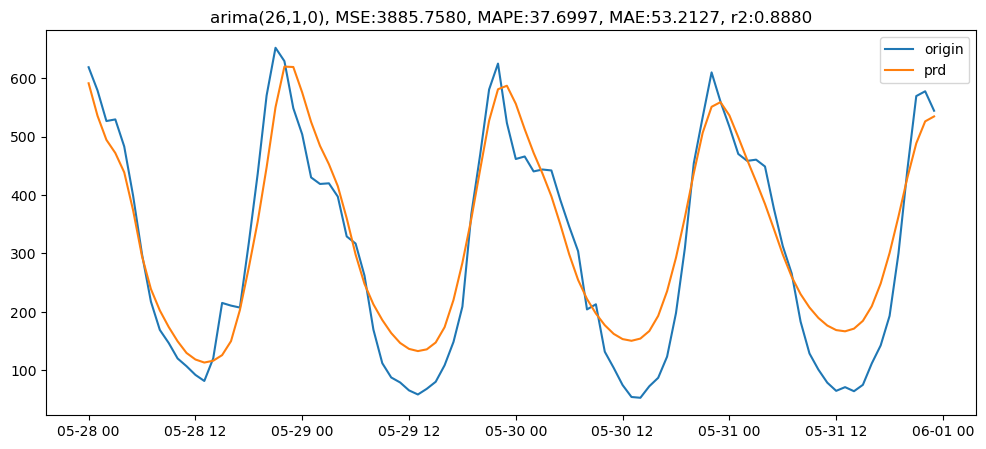

In [61]:
use_arima(df_cons0, p=26, d=1, q=0, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


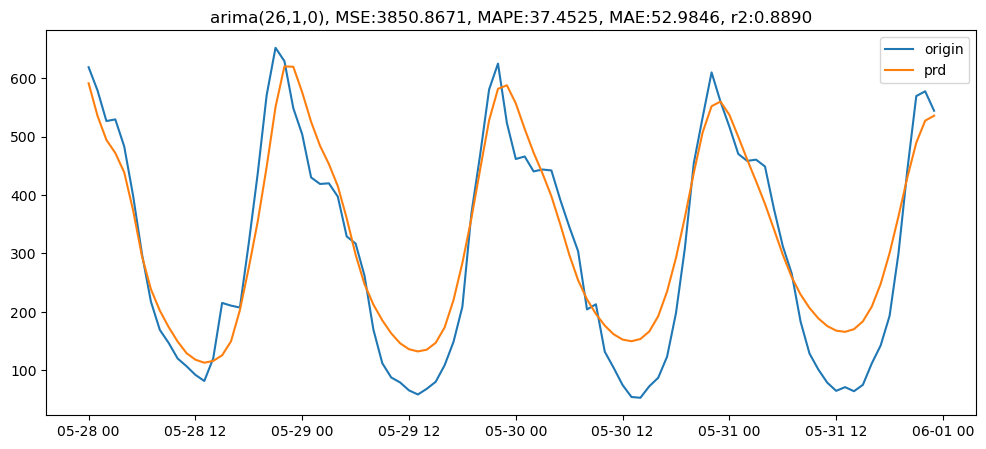

In [62]:
use_arima(df_cons0, p=26, d=1, q=0, scale=True)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/leejo/lib/python

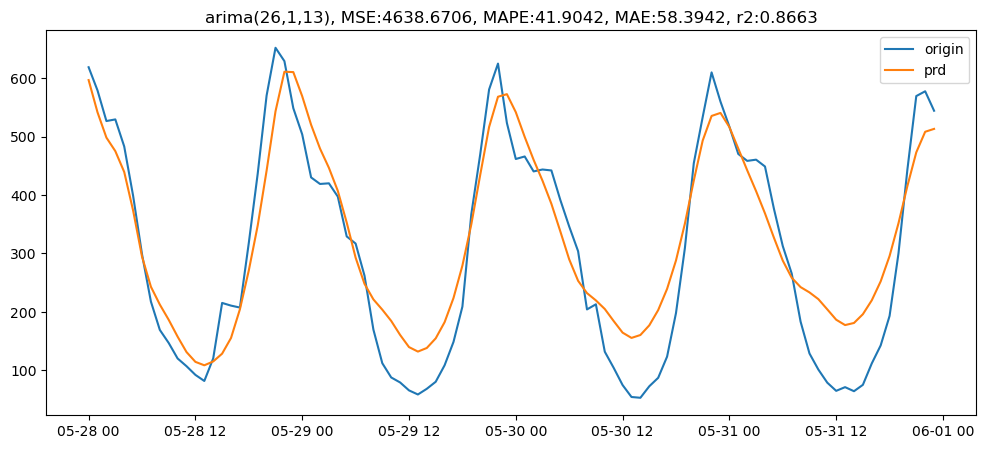

In [64]:
use_arima(df_cons0, p=26, d=1, q=13, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/leejo/lib/python

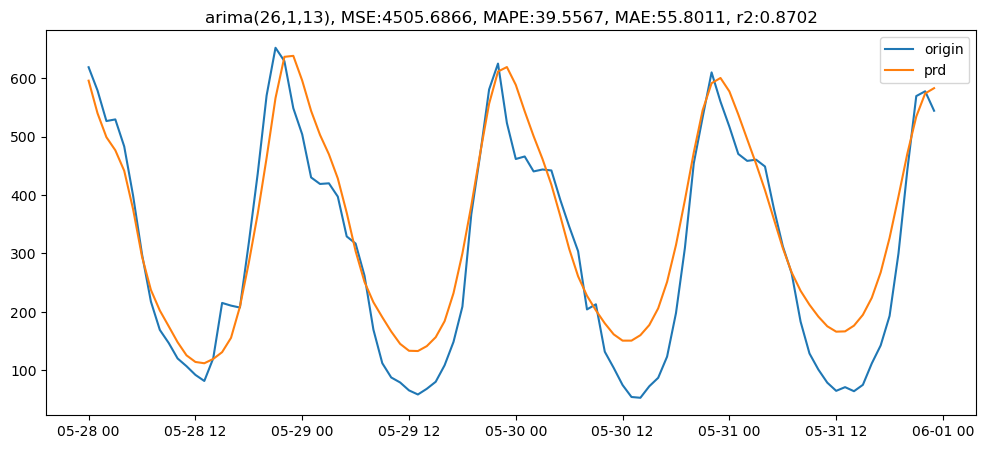

In [65]:
use_arima(df_cons0, p=26, d=1, q=13, scale=True)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/leejo/lib/python

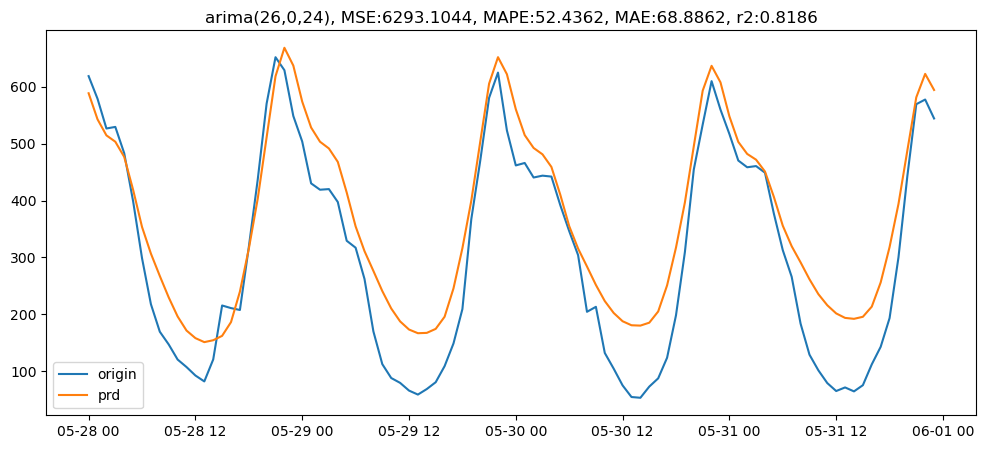

In [66]:
use_arima(df_cons0, p=26, d=0, q=24, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/leejo/lib/python

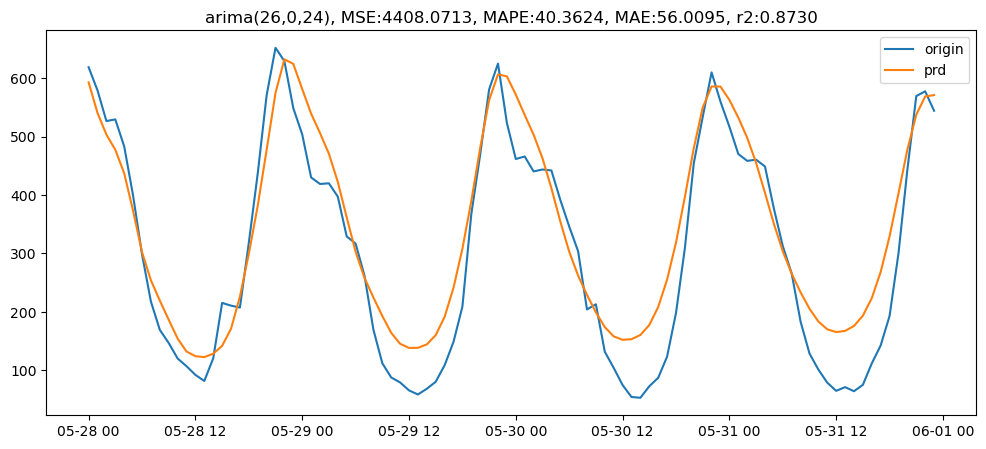

In [67]:
use_arima(df_cons0, p=26, d=0, q=24, scale=True)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/leejo/lib/python

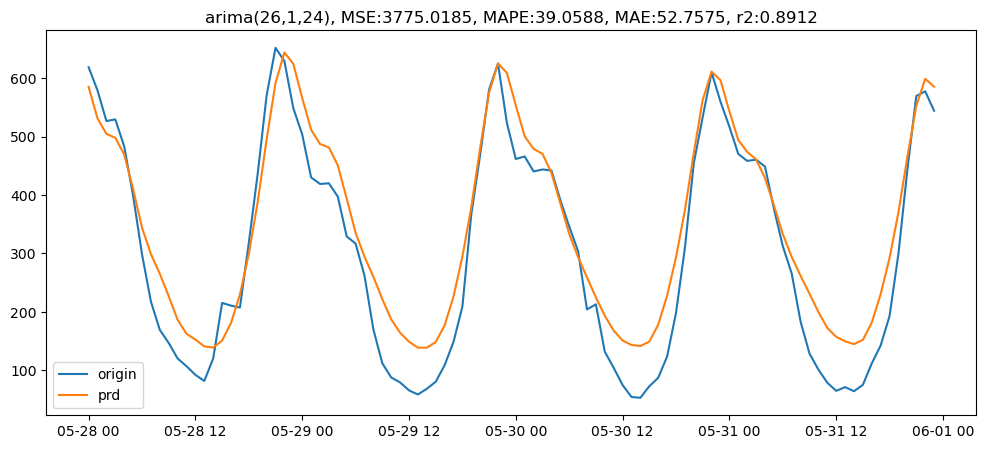

In [68]:
use_arima(df_cons0, p=26, d=1, q=24, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/leejo/lib/python

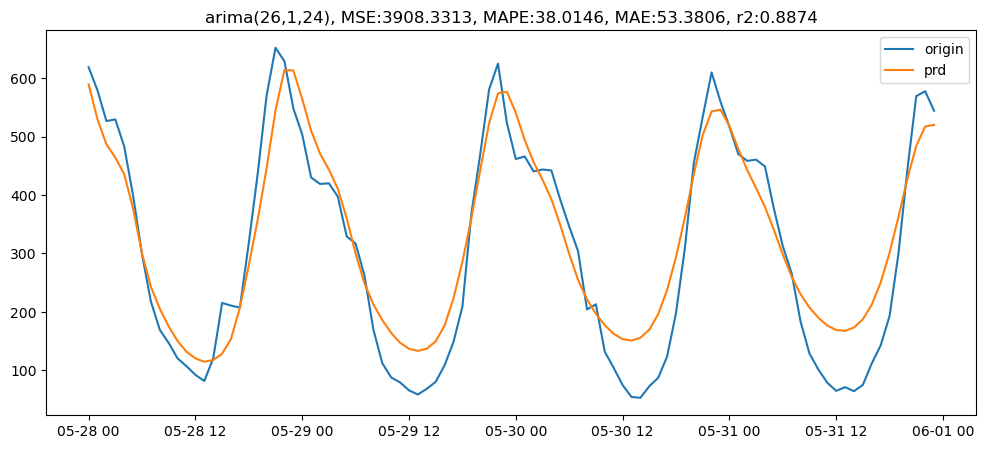

In [69]:
use_arima(df_cons0, p=26, d=1, q=24, scale=True)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)


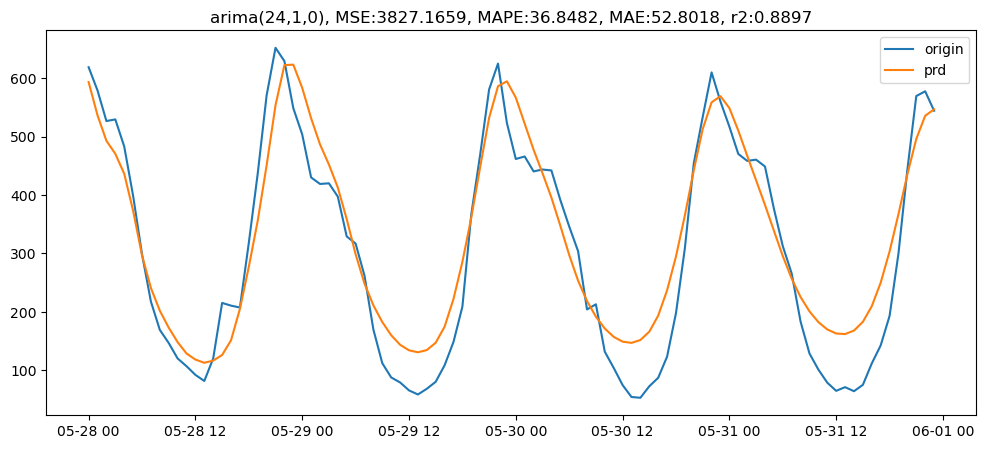

In [12]:
use_arima(df_cons0, p=24, d=1, q=0, scale=False)

/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  self._init_dates(dates, freq)
/home/estsoft/miniconda3/envs/leejo/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/estsoft/miniconda3/envs/leejo/lib/python

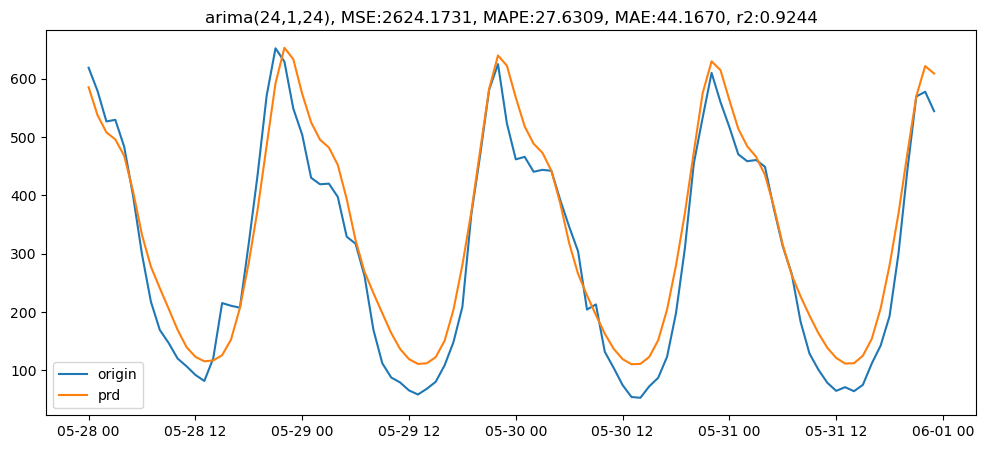

In [11]:
use_arima(df_cons0, p=24, d=1, q=24, scale=False)